# Bullet Plotter

Plotting the projectile as a spherically blunted tangent ogive

**Created by:** Andrew Smelser

**Created on:** 08-07-2020

**Updated on:** 10-28-2020

## Package Imports

In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

%matplotlib notebook

## Function Definitions

In [2]:
def _blunt_tangent_ogive(R_base=None, L_ogive=None, rn=None, rho=None, **kwargs):
    """Calculate the nose shape for a spherically blunted tangent ogive
        
        See also https://en.wikipedia.org/wiki/Nose_cone_design#Tangent_ogive
        
        :param R_base: Radius of the base, mm
        :type R_base: None, float, int
        :param L_ogive: length of the ogive, mm
        :type L_ogive: None, float, int
        :param rn: radius of the nose sphere, mm
        :type rn: None, float, int
        :param rho: ogive radius, mm
        :type rho: None, int, float
        :return xt: The x-coordinate where the ogive is tangent to the nose, mm.
        :rtype xt: int, float
        :return yt: The y-coordinate where the ogive is tangent to the nose, mm.
        :rtype yt: int, float
        :return x0: x-coord of center of circle which defines the shape of the nose, mm
        :rtype x0: int, float
        :return xa: the apex point of the nose, mm.
        :rtype xa: int, float
    """    
    if rho is None:
        # rho = (R_base**2 + L_ogive**2)/(2*R_base)
        raise ValueError('Rho cannot be None')
    x0 = L_ogive - np.sqrt((rho - rn)**2 - (rho-R_base)**2)
    yt = rn*(rho-R_base)/(rho-rn)
    xt = x0 - np.sqrt(rn**2 - yt**2)
    xa = x0 - rn  # apex point
    return xt, yt, x0, xa


def tangent_ogive(R_DICT, L_DICT, rho=None, res=1000, **kwargs):
    """Calculate the shape of a tangent ogive with nose
    
        :param R_base: Radius of the base, mm
        :type R_base: float, int
        :param L_ogive: length of the ogive, mm
        :type L_ogive: float, int
        :param res: Parametric resolution. Default is 1000.
        :type res: int
        :return xy: The n x 2 numpy array containing the x-coordinates in 
            xy[0] and the y-coordinates in xy[1]
        :rtype xy: np.array()
        :return x0: x-coord of center of circle which defines the shape of the nose, mm
        :rtype x0: int, float
        :return rn: nose radius, mm
        :rtype rn: int, float
    """
    y_coords = np.array([])
    x_coords = np.array([])
    
    R_base = R_DICT['basic'][1]
    L_ogive = L_DICT['ogive'][1]
    rn = R_DICT['tip'][1]
    if rho is None:
        rho = (R_base**2 + L_ogive**2)/(2*R_base)
    xt, yt, x0, xa = _blunt_tangent_ogive(
        R_base=R_base,
        L_ogive=L_ogive,
        rn=rn,
        rho=rho,
        res=res)
    
    for i in np.arange(0, L_ogive, L_ogive/res):
        x = i
        y = np.sqrt(rho**2 - (L_ogive-x)**2) + R_base - rho
        x_coords = np.append(x_coords, x)
        y_coords = np.append(y_coords, y)

    xnose, ynose = _nose_arc(xt=xt, yt=yt, x0=x0, rn=rn, res=res)
    x_coords = np.append(xnose, x_coords[x_coords>=xt])
    y_coords = np.append(ynose, y_coords[y_coords>=yt])    
    xy = np.vstack((x_coords, y_coords))

    if R_DICT['cannelure'][1] == 0 or L_DICT['cannelure'][1] == 0:
        print('No cannelure')
    else:
        xy_out = _cannelure_points(
            xy=xy, 
            R_cannelure=R_DICT['cannelure'][1], 
            L_cannelure=L_DICT['cannelure'][1])
        xy = np.concatenate((xy, xy_out), axis=1)

    if L_DICT['basic'][1] == 0:
        print('No straight portion')
    else:
        xy_out2 = _straight_points(
            xy=xy, 
            R_basic=R_DICT['basic'][1], 
            L_basic=L_DICT['basic'][1])
        xy = np.concatenate((xy, xy_out2), axis=1)

    if R_DICT['boat_tail'][1] == 0 or R_DICT['boat_tail'][0] is False:
        print('No boat tail')
    elif R_DICT['boat_tail'][0] == 'angle':
        xy_out3 = _boat_tail_points(
            xy=xy,
            L_bt=L_DICT['boat_tail'][1],
            R_bt=None,
            bt_angle=R_DICT['angle'])
    else:
        xy_out3 = _boat_tail_points(
            xy=xy,
            L_bt=L_DICT['boat_tail'][1],
            R_bt=R_DICT['boat_tail'][1],
            bt_angle=False)

        _x = np.array([xy_out3[0], xy_out3[0]])
        _y = np.array([xy_out3[1], 0])
        xy = np.concatenate((xy, np.vstack((_x, _y))), axis=1)            
    return xy, x0, rn


def _nose_arc(xt, yt, x0, rn, res=100):
    """Calculate the parametric coordinates for the nose
    
        :param xt: x-coord of tangency, mm
        :type xt: int, float
        :param yt: y-coord of tangency, mm
        :type yt: int, float
        :param x0: x-coord of center of circle which defines the shape of the nose, mm
        :type x0: int, float
        :param rn: nose radius, mm
        :type rn: int, float
        :param res: Parametric resolution. Default is 1000.
        :type res: int
        :return xnose: The x-coordinates which define the shape of the nose, mm.
        :rtype xnose: np.array()
        :return ynose: The y-coordinates which define the shape of the nose, mm.
        :rtype ynose: np.array()
    """
    theta0 = 0  # radians
    theta_t = (np.arctan(yt/(x0-xt)))  # radians
    theta = np.linspace(theta0, theta_t, res)  # radians
    xnose = -rn*np.cos(theta) + x0
    ynose = rn*np.sin(theta)
    xnose = np.append(xnose[xnose<=xt], xt)
    ynose = np.append(ynose[ynose<=yt], yt)
    return xnose, ynose


def blunt_ogive_plotter(xy, x0, rn, **kwargs):
    """Plot the spherically blunted ogive
    
        :param xy: The n x 2 numpy array containing the x-coordinates in 
            xy[0] and the y-coordinates in xy[1]
        :type xy: np.array()
        :param x0:
        :type x0:
        :param rn:
        :type rn:
        :return fig: The plotted figure object
        :rtype fig: plt.figure()
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)    
    circle1 = plt.Circle((x0, 0), rn, color='r', 
                         ls='-.', lw='0.5', fill=False)
    ogive_shape = ax.plot(xy[0], xy[1], color='k', 
                          ls='-', lw='1')
    ax.add_artist(circle1)
    ax.axis('equal')
    ax.set_xlabel('Length, mm')
    ax.set_ylabel('Radius, mm')
    if 'title' in kwargs.keys():
        ax.set_title(str(kwargs['title']))
    ax.grid(True, 'both')
    return fig, ax


def _straight_points(R_basic, L_basic, xy):
    """Plot the straight portion of the bullet
    
        :param R_basic: Radius, mm. Note this should be the same as ``R['base'][1]``
        :type R_basic: float, int, None
        :param L_basic: A 1x2 numpy array specifying the length of the 
            straight portion, mm. The starting x-coord is L[0], the
            ending x-coord is L[1].
        :type L_basic: float, int, None
        :param xy:
        :type xy:
        :returns:
    """
    if (R_basic or L_basic) == 0:
        return xy
    else:
        return np.vstack((xy[0][-1] + L_basic, xy[1][-1]))


def _cannelure_points(xy, R_cannelure, L_cannelure):
    """Calculate points for the Cannelure
    
        :param xy: The n x 2 numpy array containing the 
            x-coordinates in xy[0] and the y-coordinates 
            in xy[1]
        :type xy: np.array
        :param R_cannelure: i THINK this is radius of the 
            cannelure from the center axis of the projectile 
            to the outer edge of the cannelure. MAYBE. It's 
            been a while...
        :type R_cannelure: int
        :param L_cannelure: i THINK this is length of the 
            cannelure. MAYBE. Again, it's been a while...
        :type L_cannelure: int
        :returns: numpy array of the xy coordinate points 
            representing the cannelure
    """
    if R_cannelure == 0 or L_cannelure == 0:
        return xy
    else:
        y1 = R_cannelure
        y2 = R_cannelure
        y3 = xy[1][-1]
        x1 = xy[0][-1]
        x2 = x1 + L_cannelure
        x3 = x1 + L_cannelure
        x = np.array([x1, x2, x3])
        y = np.array([y1, y2, y3])
        return np.vstack((x, y))
    
    
def _boat_tail_points(xy, L_bt, R_bt=None, bt_angle=False):
    """Calculate points for the boat tail
        
        :param xy: The n x 2 numpy array containing the 
            x-coordinates in xy[0] and the y-coordinates 
            in xy[1]
        :type xy: np.array
        :param L_bt: Length of the boat tail
        :type L_bt: int, float
        :param R_bt: Radius of the boat tail? Maybe?
        :type R_bt: int, float
        :param bt_angle: Angle from the horizontal 
            (maybe?) that the boat tail makes. Give 
            value in degrees. It will automatically 
            be converted to radians.
        :type bt_angle: int, float
        :raises: ValueError if R_bt is not None and 
            bt_angle is not False.
    """
    x0 = xy[0][-1]
    x1 = x0 + L_bt
    if R_bt is not None:
        y1 = R_bt
    elif bt_angle is not False:
        dy = L_bt * np.tan(bt_angle * np.pi/180)
        y1 = xy[1][-1] - dy
    else:
        raise ValueError('R_bt or bt_angle must be supplied as a numeric value.')
    return np.array([x1, y1])

    
def save_points_to_file(points, filename, extension='.csv'):
    """Save the xy-coordinates to a file
    
        :param points: The xy-coordinates representing 
            the axisymmetric profile of the projectile
        :type points: np.array
        :param filename: The name of the file to which 
            the points will be saved.
        :type filename: str, Pathlike
        :param extension: the file extension. Default 
            is .csv
        :type extension: str
        :returns: None
    """
    if '.' not in extension:
        extension = '.' + extension
    filename = os.path.join(os.getcwd(), filename + extension)
    if points.shape[1] != 2:
        points = points.T
        assert(points.shape[1] == 2), f'shape of array is invalid. {points.shape}'
    df = pd.DataFrame(data=points, columns=['X', 'Y'])
    df.to_csv(filename, index=False, header=True, quoting=1)
    return None


def print_to_openscad(xy, filename=None):
    """Print the xy-coordinates to an OpenSCAD file
    
        :param xy: The n x 2 numpy array containing the 
            x-coordinates in xy[0] and the y-coordinates 
            in xy[1]
        :type xy: np.array
        :param filename: The name of the openscad file. 
            Default is 'polygon_points.scad'
        :type filename: None, str, Pathlike
    """
    if filename is None:
        openscad_file = r"polygon_points.scad"
    else:
        openscad_file = f'{filename}.scad'
    xy = xy.T
    openscad_file = os.path.join(os.getcwd(), openscad_file)
    with open(openscad_file, 'w') as f:
        f.write(r"$fa = 0.5;")
        f.write("\n")
        f.write(r"$fs = 0.5;")
        f.write("\n")
        f.write(f"translate([0,0,{xy[-1][0]-xy[0][0]}])")
        f.write("{\n")
        f.write("\trotate_extrude($fn=200){\n")
        f.write("\t\trotate([0,0,-90]){\n")
        f.write("\t\t\tpolygon(points=[\n")
        for i in range(xy.shape[0]):
            line = f'\t\t\t\t[{xy[i][0]-xy[0][0]}, {xy[i][1]}],\n'  # x-offset to start polygon at origin
            f.write(line)
        f.write("\t\t\t]);\n\t\t};\n\t};\n};")


# ===================== #
#     Main function     #
# ===================== #

def main(R_dict, L_dict, res=1000, **kwargs):
    """Run all the code to make the projectile profile
    
        :param R_dict: The dictionary containing all the radius values
        :type R_dict: dict
        :param L_dict: The dictionary containing all the length values
        :type L_dict: dict
        :param res: The resolution of the coordinates. Default is 1000
        :type res: int
        :param kwargs: Key-word arguments. Will be passed to 
            print_to_openscad(), save_points_to_file, and/or 
            blunt_ogive_plotter. See the docstring of those 
            functions for information on their inputs.
        :type kwargs: dict
        :returns: A numpy array of the xy-coordinates representing the 
            axisymmetric profile of the projectile.
    """
    if 'angle' in kwargs.keys():
        R_dict['angle'] = kwargs['angle']
        R_dict['boat_tail'][0] = ['angle']
    R_base = R_dict['basic'][1]
    L_ogive = L_dict['ogive'][1]
    r_nose = R_dict['tip'][1]
    rho = R_dict['rho'][1]
    xy, x0, rn = tangent_ogive(R_DICT=R_dict, L_DICT=L_dict, res=res)
    plotted_ogive_w_nose, fig_ax = blunt_ogive_plotter(xy=xy, x0=x0, rn=rn, **kwargs)
    
    # TODO: add boat tail function to calculate the points for plotting the boat tail
    if 'filename' in kwargs.keys():
        filename = kwargs['filename']
        save_points_to_file(points=xy, filename=filename, extension='csv')
    if 'openscad' in kwargs.keys():
        print_to_openscad(xy=xy, filename=kwargs['openscad'])
    return xy

## Calling Code and Running

<IPython.core.display.Javascript object>


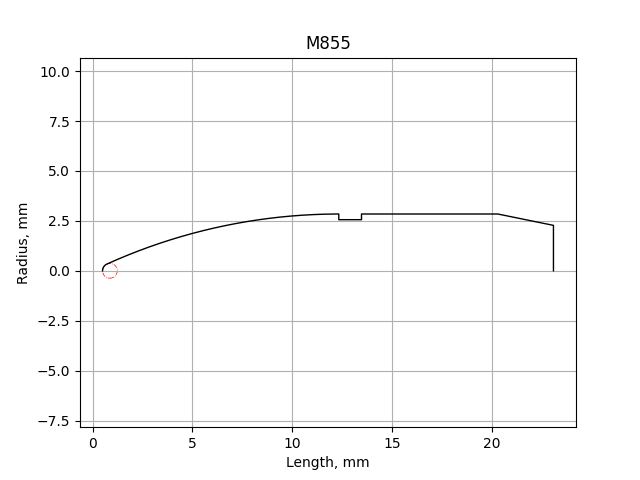

In [3]:
caliber = 5.69  # 1 caliber = 5.69mm
R = {'tip': 0.13/2, 
     'ogive': np.nan, 
     'basic': 1/2, 
     'cannelure': 0.9/2, 
     'boat_tail': 0.8/2, 
     'heel': 0.13}
R = {k: [v, v*caliber] for k, v in R.items()}
L = {'boat_tail': 0.49, 
     'basic': 1.2, 
     'cannelure': 0.2, 
     'ogive': 2.17}
L = {k: [v, v*caliber] for k, v in L.items()}

L['OAL'] = [[sum([x[0] for x in L.values()])], 
            [sum([x[1] for x in L.values()])]]
R['rho'] = [(R['basic'][0]**2 + L['ogive'][0]**2)/(2*R['basic'][0]), 
            (R['basic'][1]**2 + L['ogive'][1]**2)/(2*R['basic'][1])]

main_kw = {'title': 'M855', 'filename': 'm855', 'openscad': 'm855_62gr'}
xy = main(R_dict=R, L_dict=L, res=1000, **main_kw)